## 

# 2. Basic Graph AE + GNN for node classification from AE codings
super basic 2 GCNConv layers  
2-dim output

## 

In [1]:
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
from sklearn.neighbors import kneighbors_graph
import numpy as np
from torch_geometric.data import Data
from scipy.sparse import coo_matrix
from utils import *
from torch_geometric.utils import train_test_split_edges

# Load the Fashion-MNIST dataset
def load_fmnist():
    transform = transforms.Compose([transforms.ToTensor()])
    train_dataset = datasets.FashionMNIST(root='.', train=True, transform=transform, download=True)
    return train_dataset

# Convert images to feature vectors
def preprocess_data(dataset):
    data = dataset.data.numpy()
    num_samples = data.shape[0]
    data = data.reshape(num_samples, -1) / 255.0
    labels = dataset.targets.numpy()
    return data, labels

# Create a KNN graph
def create_knn_graph(data, k):
    knn_graph = kneighbors_graph(data, k, mode='connectivity', include_self=False)
    return knn_graph

# Convert the sparse matrix to edge_index format for PyTorch Geometric
def convert_to_torch_geometric_graph(knn_graph):
    coo = coo_matrix(knn_graph)
    edge_index = torch.tensor(np.vstack((coo.row, coo.col)), dtype=torch.long)
    return edge_index

# Main function to execute the steps
def main():
    # Load and preprocess the data
    train_dataset = load_fmnist()
    x_train, y_train = preprocess_data(train_dataset)
    
    # Use a subset of the data for simplicity (e.g., first 1000 samples)
    x_subset = x_train[:1000]
    y_subset = y_train[:1000]
    
    # Create KNN graph
    k = 4  # Number of neighbors
    knn_graph = create_knn_graph(x_subset, k)
    
    # Convert to PyTorch Geometric Data object
    edge_index = convert_to_torch_geometric_graph(knn_graph)
    x = torch.tensor(x_subset, dtype=torch.float)
    y = torch.tensor(y_subset, dtype=torch.long)
    data = Data(x=x, edge_index=edge_index, y=y)
    
    # Set additional attributes for compatibility
    data.num_node_features = data.x.shape[1]
    data.num_classes = len(torch.unique(data.y))
    data.num_features = data.num_node_features
    
    # Print the Data object to verify
    print(data)
    print(f"Number of node features: {data.num_node_features}")
    print(f"Number of classes: {data.num_classes}")
    print(f"Number of features: {data.num_features}")

    
    return data



data = main()
generate_train_test(data)
data = train_test_split_edges(data)

# # Load the Cora dataset
# dataset = Planetoid(root='.', name='Cora', transform=NormalizeFeatures())
# data = dataset[0]

Data(x=[1000, 784], edge_index=[2, 4000], y=[1000], num_node_features=784, num_classes=10, num_features=784)
Number of node features: 784
Number of classes: 10
Number of features: 784


/home/asemerjak/.local/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


In [2]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.nn import GCNConv, GAE, VGAE, LayerNorm
from torch_geometric.utils import train_test_split_edges
from utils import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class BasicVGAEEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(BasicVGAEEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels)
        self.conv2_mu = GCNConv(2 * out_channels, out_channels)
        self.conv2_logstd = GCNConv(2 * out_channels, out_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        return self.conv2_mu(x, edge_index), self.conv2_logstd(x, edge_index)

# dataset = Planetoid(root='.', name='Cora', transform=NormalizeFeatures())
# data = dataset[0]
# data = train_test_split_edges(data)

# Model initialization
in_channels = data.num_features
out_channels = 2
model = VGAE(BasicVGAEEncoder(in_channels, out_channels)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training the VGAE model
for epoch in range(1, 101):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x.to(device), data.train_pos_edge_index.to(device))
    loss = model.recon_loss(z, data.train_pos_edge_index)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item()}')

# Update data.x with the encoded features for classification
data.x = model.encode(data.x.to(device), data.train_pos_edge_index.to(device)).detach()

class GNNNodeClassifier(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GNNNodeClassifier, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels, cached=True)
        self.conv2 = GCNConv(hidden_channels, out_channels, cached=True)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Initialize the GNN model for node classification
hidden_channels = 16
num_classes = data.num_classes
gnn_model = GNNNodeClassifier(out_channels, hidden_channels, num_classes).to(device)
optimizer_gnn = torch.optim.Adam(gnn_model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

# Reconstruct full edge_index from the split edges for training the GNN
full_edge_index = torch.cat([data.train_pos_edge_index, data.val_pos_edge_index, data.test_pos_edge_index], dim=1).to(device)

# Training the GNN model
for epoch in range(100):
    gnn_model.train()
    optimizer_gnn.zero_grad()
    out = gnn_model(data.x, full_edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask].to(device))
    loss.backward()
    optimizer_gnn.step()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

# Evaluation
gnn_model.eval()
with torch.no_grad():
    out = gnn_model(data.x, full_edge_index)
    pred = out.argmax(dim=1)
    correct = (pred[data.test_mask] == data.y[data.test_mask].to(device)).sum()
    acc = correct.float() / data.test_mask.sum().float()
    print(f'Accuracy: {acc.item()}')


Epoch: 10, Loss: 1.7173130512237549
Epoch: 20, Loss: 1.5941078662872314
Epoch: 30, Loss: 1.5489240884780884
Epoch: 40, Loss: 1.5020263195037842
Epoch: 50, Loss: 1.4964869022369385
Epoch: 60, Loss: 1.4718225002288818
Epoch: 70, Loss: 1.4256185293197632
Epoch: 80, Loss: 1.4421800374984741
Epoch: 90, Loss: 1.4287550449371338
Epoch: 100, Loss: 1.431102991104126
Epoch 0, Loss: 2.3033664226531982
Epoch 10, Loss: 2.277669668197632
Epoch 20, Loss: 2.261516809463501
Epoch 30, Loss: 2.2491419315338135
Epoch 40, Loss: 2.2427587509155273
Epoch 50, Loss: 2.2112159729003906
Epoch 60, Loss: 2.2160909175872803
Epoch 70, Loss: 2.2068047523498535
Epoch 80, Loss: 2.2072861194610596
Epoch 90, Loss: 2.19577693939209
Accuracy: 0.17000000178813934


## 

In [3]:
print(f'Accuracy: {acc:.4f}')

Accuracy: 0.1700


# 3. Basic Graph AE + GNN for node classification from AE codings
super basic 2 GCNConv layers  
16-dim output

## 

In [4]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.nn import GCNConv, GAE
from torch_geometric.utils import train_test_split_edges

class BasicVGAEEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(BasicVGAEEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels)
        self.conv2_mu = GCNConv(2 * out_channels, out_channels)
        self.conv2_logstd = GCNConv(2 * out_channels, out_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        return self.conv2_mu(x, edge_index), self.conv2_logstd(x, edge_index)


data = main()
generate_train_test(data)
data = train_test_split_edges(data)


class GNNNodeClassifier(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GNNNodeClassifier, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels, cached=True)
        self.conv2 = GCNConv(hidden_channels, out_channels, cached=True)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Parameters
out_channels = 16
num_features = data.num_features
num_classes = data.num_classes
epochs = 100
hidden_channels = 32

# Model initialization
model = VGAE(BasicVGAEEncoder(num_features, out_channels)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training the GAE model
for epoch in range(1, epochs + 1):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x.to(device), data.train_pos_edge_index.to(device))
    loss = model.recon_loss(z, data.train_pos_edge_index)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item()}')

# Update data.x with the encoded features for classification
data.x = model.encode(data.x.to(device), data.train_pos_edge_index.to(device)).detach()

# Initialize the GNN model for node classification
gnn_model = GNNNodeClassifier(out_channels, hidden_channels, num_classes).to(device)
optimizer_gnn = torch.optim.Adam(gnn_model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

# Reconstruct full edge_index from the split edges for training the GNN
full_edge_index = torch.cat([data.train_pos_edge_index, data.val_pos_edge_index, data.test_pos_edge_index], dim=-1).to(device)

# Training the GNN model
for epoch in range(100):
    gnn_model.train()
    optimizer_gnn.zero_grad()
    out = gnn_model(data.x, full_edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask].to(device))
    loss.backward()
    optimizer_gnn.step()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

# Evaluation
gnn_model.eval()
with torch.no_grad():
    out = gnn_model(data.x, full_edge_index)
    pred = out.argmax(dim=1)
    correct = (pred[data.test_mask] == data.y[data.test_mask].to(device)).sum()
    acc = correct.float() / data.test_mask.sum().float()
    


Data(x=[1000, 784], edge_index=[2, 4000], y=[1000], num_node_features=784, num_classes=10, num_features=784)
Number of node features: 784
Number of classes: 10
Number of features: 784


/home/asemerjak/.local/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


Epoch: 10, Loss: 2.724761486053467
Epoch: 20, Loss: 1.7728192806243896
Epoch: 30, Loss: 1.279478669166565
Epoch: 40, Loss: 1.1190367937088013
Epoch: 50, Loss: 1.0709346532821655
Epoch: 60, Loss: 1.0650660991668701
Epoch: 70, Loss: 1.0350342988967896
Epoch: 80, Loss: 1.0540677309036255
Epoch: 90, Loss: 1.0376275777816772
Epoch: 100, Loss: 1.0642626285552979
Epoch 0, Loss: 2.2957334518432617
Epoch 10, Loss: 1.7118654251098633
Epoch 20, Loss: 1.4609440565109253
Epoch 30, Loss: 1.3449218273162842
Epoch 40, Loss: 1.2770756483078003
Epoch 50, Loss: 1.2388029098510742
Epoch 60, Loss: 1.2185298204421997
Epoch 70, Loss: 1.1693710088729858
Epoch 80, Loss: 1.176977276802063
Epoch 90, Loss: 1.1610339879989624


## 

In [5]:
print(f'Accuracy: {acc:.4f}')

Accuracy: 0.5450


# 4. Basic Graph AE for DR
super basic 2 GCNConv layers  
2-dim output straight for visualisation

## 

In [6]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.nn import GCNConv, GAE
from torch_geometric.utils import train_test_split_edges
import matplotlib.pyplot as plt

class BasicVGAEEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(BasicVGAEEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels)
        self.conv2_mu = GCNConv(2 * out_channels, out_channels)
        self.conv2_logstd = GCNConv(2 * out_channels, out_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        return self.conv2_mu(x, edge_index), self.conv2_logstd(x, edge_index)


data = main()
generate_train_test(data)
data = train_test_split_edges(data)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Parameters for visualization
out_channels = 2  # Set to 2 for 2D visualization
num_features = data.num_features

model = VGAE(BasicVGAEEncoder(num_features, out_channels)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training the GAE model to encode node features into 2D
for epoch in range(1, 101):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x.to(device), data.train_pos_edge_index.to(device))
    loss = model.recon_loss(z, data.train_pos_edge_index)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item()}')

# Encode and detach the features for visualization
encoded_features = model.encode(data.x.to(device), data.train_pos_edge_index.to(device)).detach().cpu().numpy()

# Visualization of the 2D encoded features
labels = data.y.cpu().numpy()



Data(x=[1000, 784], edge_index=[2, 4000], y=[1000], num_node_features=784, num_classes=10, num_features=784)
Number of node features: 784
Number of classes: 10
Number of features: 784


/home/asemerjak/.local/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


Epoch: 10, Loss: 1.5099836587905884
Epoch: 20, Loss: 1.3887187242507935
Epoch: 30, Loss: 1.3634812831878662
Epoch: 40, Loss: 1.3512458801269531
Epoch: 50, Loss: 1.3390495777130127
Epoch: 60, Loss: 1.3219397068023682
Epoch: 70, Loss: 1.3062951564788818
Epoch: 80, Loss: 1.2856597900390625
Epoch: 90, Loss: 1.250185251235962
Epoch: 100, Loss: 1.2275466918945312


## 

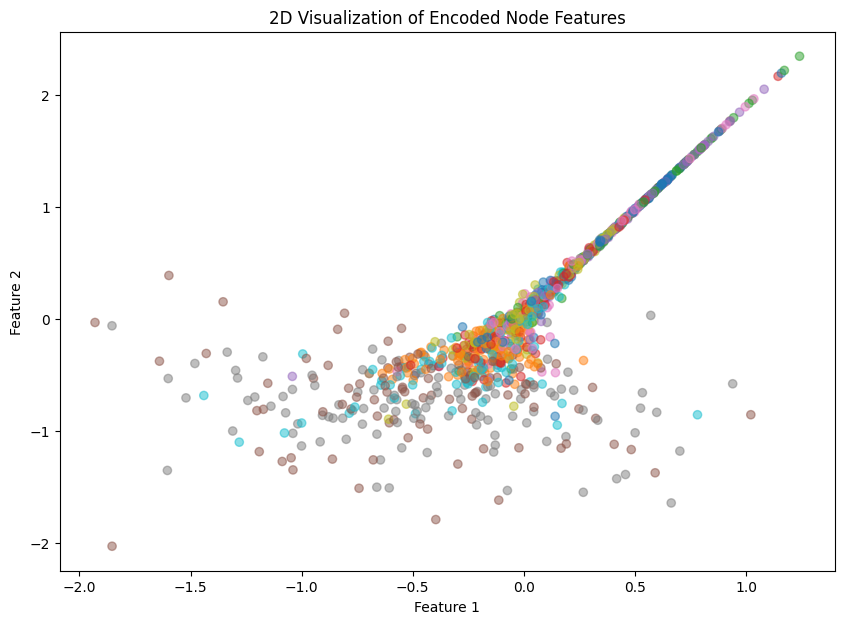

In [7]:
visualise(encoded_features, labels, '2D Visualization of Encoded Node Features')

# 5. Basic Graph AE + tSNE
super basic 2 GCNConv layers  
16-dim output -> tSNE (2dim)

## 

In [8]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.nn import GCNConv, GAE
from torch_geometric.utils import train_test_split_edges
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


# Parameters for the encoder
out_channels = 16  # Increase the capacity
num_features = data.num_features

# Model initialization
model = VGAE(BasicVGAEEncoder(num_features, out_channels)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # Add weight decay for L2 regularization

# Training the GAE model
for epoch in range(1, 201):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x.to(device), data.train_pos_edge_index.to(device))
    loss = model.recon_loss(z, data.train_pos_edge_index)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item()}')

# Encode to a higher dimension for better representation, then use t-SNE
encoded_features = model.encode(data.x.to(device), data.train_pos_edge_index.to(device)).detach().cpu().numpy()

# Apply t-SNE to the encoded features
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
tsne_results = tsne.fit_transform(encoded_features)



Epoch: 10, Loss: 2.561718225479126
Epoch: 20, Loss: 1.6590474843978882
Epoch: 30, Loss: 1.260711908340454
Epoch: 40, Loss: 1.0976271629333496
Epoch: 50, Loss: 1.0298033952713013
Epoch: 60, Loss: 1.0218950510025024
Epoch: 70, Loss: 1.0139724016189575
Epoch: 80, Loss: 1.0086228847503662
Epoch: 90, Loss: 0.9957090616226196
Epoch: 100, Loss: 0.9992337226867676
Epoch: 110, Loss: 0.9859670400619507
Epoch: 120, Loss: 0.966999888420105
Epoch: 130, Loss: 0.9630287289619446
Epoch: 140, Loss: 0.9477972388267517
Epoch: 150, Loss: 0.965979814529419
Epoch: 160, Loss: 0.9638082981109619
Epoch: 170, Loss: 0.9646672606468201
Epoch: 180, Loss: 0.9550160765647888
Epoch: 190, Loss: 0.97308349609375
Epoch: 200, Loss: 0.948045015335083


## 

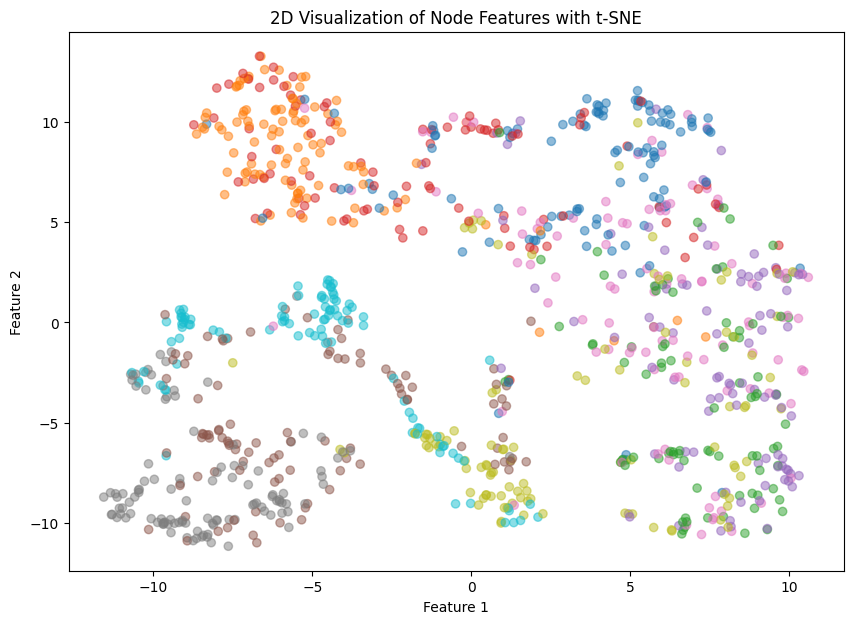

In [9]:
visualise(tsne_results, labels, '2D Visualization of Node Features with t-SNE')

# 6. Graph AE with skip connections +tSNE
Three GCNConv layers with a skip connection

## 

In [10]:
class SkipVGAEEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(SkipVGAEEncoder, self).__init__()
        self.base_conv1 = GCNConv(in_channels, 2 * out_channels)
        self.skip_conv1 = GCNConv(in_channels, 2 * out_channels)
        self.conv2_mu = GCNConv(2 * out_channels, out_channels)
        self.conv2_logstd = GCNConv(2 * out_channels, out_channels)

    def forward(self, x, edge_index):
        skip1 = F.relu(self.skip_conv1(x, edge_index))
        x = F.relu(self.base_conv1(x, edge_index))
        x = x + skip1
        return self.conv2_mu(x, edge_index), self.conv2_logstd(x, edge_index)


# Parameters for the encoder
out_channels = 16  # Increase the capacity
num_features = data.num_features

# Model initialization
model = VGAE(SkipVGAEEncoder(num_features, out_channels)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # Add weight decay for L2 regularization

# Training the GAE model
for epoch in range(1, 201):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x.to(device), data.train_pos_edge_index.to(device))
    loss = model.recon_loss(z, data.train_pos_edge_index)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item()}')

# Encode to a higher dimension for better representation, then use t-SNE
encoded_features = model.encode(data.x.to(device), data.train_pos_edge_index.to(device)).detach().cpu().numpy()

# Apply t-SNE to the encoded features
tsne = TSNE(n_components=2, perplexity=30, n_iter=300, metric='cosine')
tsne_results = tsne.fit_transform(encoded_features)

# Visualization of the 2D t-SNE results
labels = data.y.cpu().numpy()



Epoch: 10, Loss: 33.215171813964844
Epoch: 20, Loss: 32.96247100830078
Epoch: 30, Loss: 34.339473724365234
Epoch: 40, Loss: 34.21989440917969
Epoch: 50, Loss: 34.00066375732422
Epoch: 60, Loss: 35.07688522338867
Epoch: 70, Loss: 34.52880859375
Epoch: 80, Loss: 34.11027908325195
Epoch: 90, Loss: 34.588600158691406
Epoch: 100, Loss: 34.70817947387695
Epoch: 110, Loss: 34.56867218017578
Epoch: 120, Loss: 35.16657257080078
Epoch: 130, Loss: 34.51884460449219
Epoch: 140, Loss: 34.56867218017578
Epoch: 150, Loss: 34.578636169433594
Epoch: 160, Loss: 35.09681701660156
Epoch: 170, Loss: 34.23982238769531
Epoch: 180, Loss: 34.339473724365234
Epoch: 190, Loss: 35.46552276611328
Epoch: 200, Loss: 35.06692123413086


## 

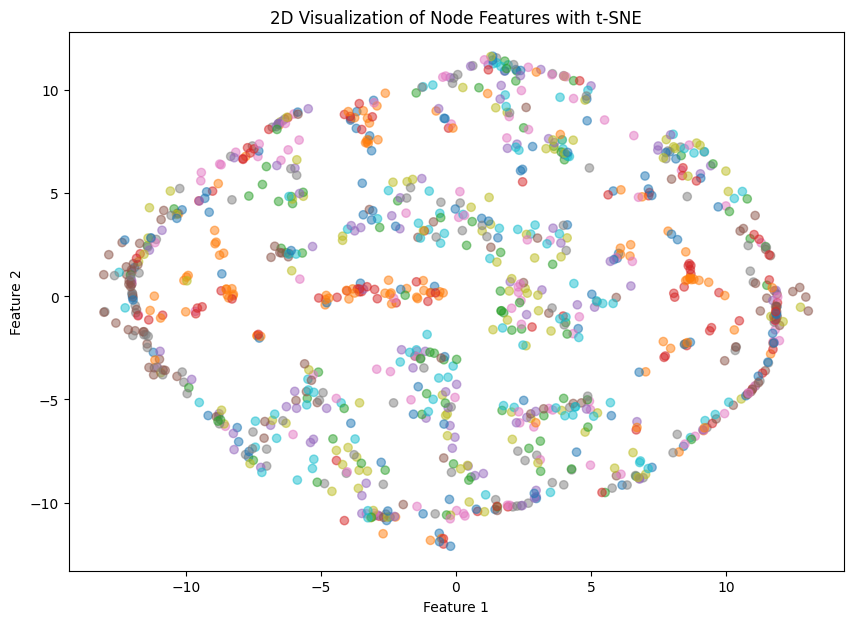

In [11]:
visualise(tsne_results, labels, '2D Visualization of Node Features with t-SNE')

# 7. Graph AE with skip connections
Three GCNConv layers with a skip connection

## 

In [12]:
data = main()
generate_train_test(data)
data = train_test_split_edges(data)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Parameters for visualization
out_channels = 2  # Set to 2 for 2D visualization
num_features = data.num_features

model = VGAE(SkipVGAEEncoder(num_features, out_channels)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training the GAE model to encode node features into 2D
for epoch in range(1, 101):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x.to(device), data.train_pos_edge_index.to(device))
    loss = model.recon_loss(z, data.train_pos_edge_index)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item()}')

# Encode and detach the features for visualization
encoded_features = model.encode(data.x.to(device), data.train_pos_edge_index.to(device)).detach().cpu().numpy()

# Visualization of the 2D encoded features
labels = data.y.cpu().numpy()



Data(x=[1000, 784], edge_index=[2, 4000], y=[1000], num_node_features=784, num_classes=10, num_features=784)
Number of node features: 784
Number of classes: 10
Number of features: 784


/home/asemerjak/.local/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


Epoch: 10, Loss: 1.6951279640197754
Epoch: 20, Loss: 1.6181704998016357
Epoch: 30, Loss: 1.5760903358459473
Epoch: 40, Loss: 1.5224215984344482
Epoch: 50, Loss: 1.4850947856903076
Epoch: 60, Loss: 1.4753419160842896
Epoch: 70, Loss: 1.4692730903625488
Epoch: 80, Loss: 1.415245771408081
Epoch: 90, Loss: 1.4288791418075562
Epoch: 100, Loss: 1.4417122602462769


## 

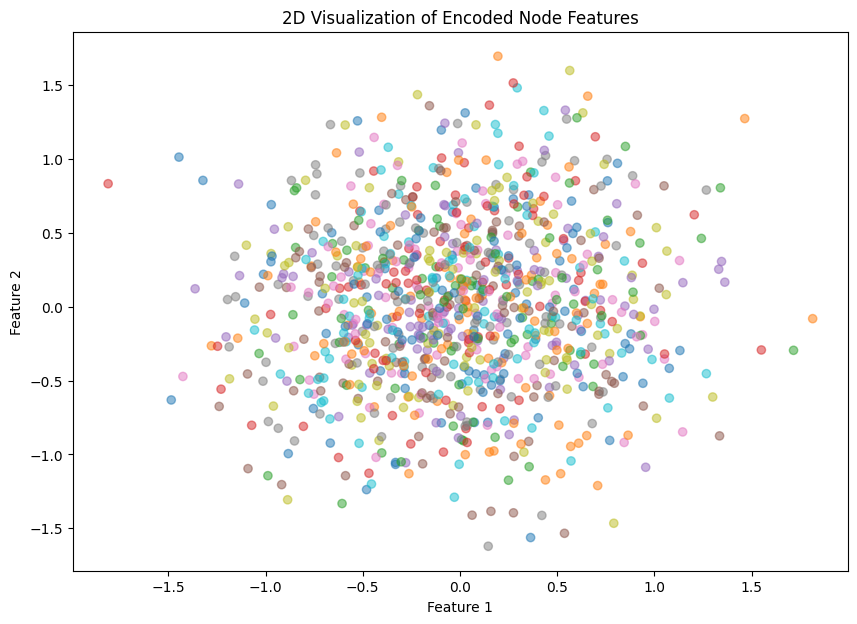

In [13]:
visualise(encoded_features, labels, '2D Visualization of Encoded Node Features')


# 8. Graph AE with attention
Two GATConv layers.

## 

In [14]:
from torch_geometric.nn import GATConv

class GATVGAEEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GATVGAEEncoder, self).__init__()
        self.conv1 = GATConv(in_channels, 2 * out_channels, heads=8, dropout=0.6)
        self.conv2_mu = GATConv(2 * out_channels * 8, out_channels, heads=1, concat=False, dropout=0.6)
        self.conv2_logstd = GATConv(2 * out_channels * 8, out_channels, heads=1, concat=False, dropout=0.6)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.elu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.6, training=self.training)
        return self.conv2_mu(x, edge_index), self.conv2_logstd(x, edge_index)


data = main()
generate_train_test(data)
data = train_test_split_edges(data)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Parameters for visualization
out_channels = 2  # Set to 2 for 2D visualization
num_features = data.num_features

model = VGAE(GATVGAEEncoder(num_features, out_channels)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training the GAE model to encode node features into 2D
for epoch in range(1, 201):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x.to(device), data.train_pos_edge_index.to(device))
    loss = model.recon_loss(z, data.train_pos_edge_index)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item()}')

# Encode and detach the features for visualization
encoded_features = model.encode(data.x.to(device), data.train_pos_edge_index.to(device)).detach().cpu().numpy()

Data(x=[1000, 784], edge_index=[2, 4000], y=[1000], num_node_features=784, num_classes=10, num_features=784)
Number of node features: 784
Number of classes: 10
Number of features: 784


/home/asemerjak/.local/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


Epoch: 10, Loss: 5.2635650634765625
Epoch: 20, Loss: 2.415696382522583
Epoch: 30, Loss: 2.087066650390625
Epoch: 40, Loss: 1.6663962602615356
Epoch: 50, Loss: 1.4882371425628662
Epoch: 60, Loss: 1.481731653213501
Epoch: 70, Loss: 1.578732967376709
Epoch: 80, Loss: 1.4077337980270386
Epoch: 90, Loss: 1.4393882751464844
Epoch: 100, Loss: 1.3886687755584717
Epoch: 110, Loss: 1.4171289205551147
Epoch: 120, Loss: 1.380833625793457
Epoch: 130, Loss: 1.3772130012512207
Epoch: 140, Loss: 1.3745447397232056
Epoch: 150, Loss: 1.308387279510498
Epoch: 160, Loss: 1.337972640991211
Epoch: 170, Loss: 1.3083255290985107
Epoch: 180, Loss: 1.315826177597046
Epoch: 190, Loss: 1.291817545890808
Epoch: 200, Loss: 1.3230741024017334


## 

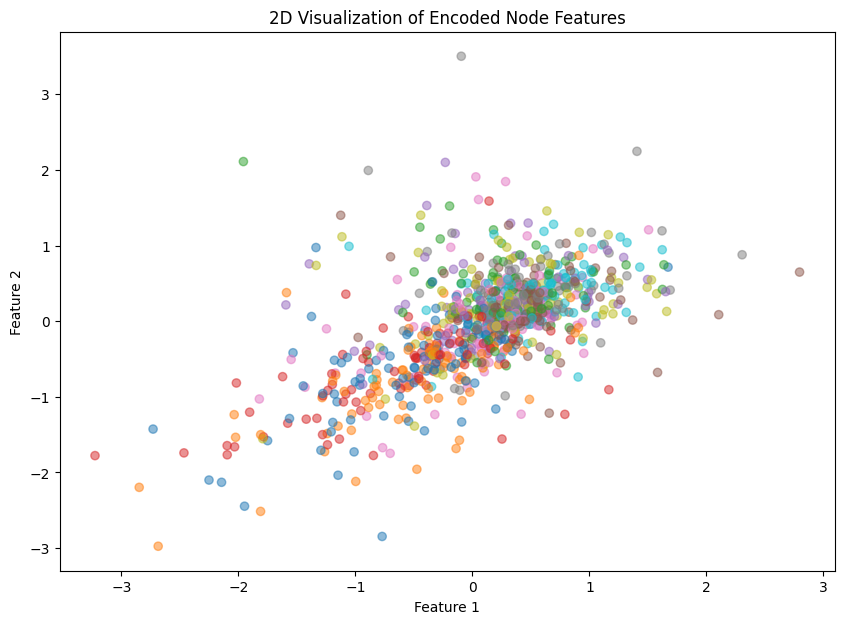

In [15]:
visualise(encoded_features, labels, '2D Visualization of Encoded Node Features')

# 8. Graph AE with attention + tSNE
Two GATConv layers.

## 

In [16]:
# Parameters for the encoder
out_channels = 16  # Increase the capacity
num_features = data.num_features

# Model initialization
model = VGAE(GATVGAEEncoder(num_features, out_channels)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # Add weight decay for L2 regularization

# Training the GAE model
for epoch in range(1, 201):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x.to(device), data.train_pos_edge_index.to(device))
    loss = model.recon_loss(z, data.train_pos_edge_index)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item()}')

# Encode to a higher dimension for better representation, then use t-SNE
encoded_features = model.encode(data.x.to(device), data.train_pos_edge_index.to(device)).detach().cpu().numpy()

# Apply t-SNE to the encoded features
tsne = TSNE(n_components=2, perplexity=30, n_iter=300, metric='cosine')
tsne_results = tsne.fit_transform(encoded_features)

# Visualization of the 2D t-SNE results
labels = data.y.cpu().numpy()




Epoch: 10, Loss: 12.647077560424805
Epoch: 20, Loss: 10.226173400878906
Epoch: 30, Loss: 10.100144386291504
Epoch: 40, Loss: 9.250572204589844
Epoch: 50, Loss: 9.259605407714844
Epoch: 60, Loss: 9.158853530883789
Epoch: 70, Loss: 7.785891532897949
Epoch: 80, Loss: 7.977065086364746
Epoch: 90, Loss: 8.257712364196777
Epoch: 100, Loss: 8.635068893432617
Epoch: 110, Loss: 8.839879989624023
Epoch: 120, Loss: 9.220619201660156
Epoch: 130, Loss: 8.369196891784668
Epoch: 140, Loss: 8.416009902954102
Epoch: 150, Loss: 9.561891555786133
Epoch: 160, Loss: 8.35044002532959
Epoch: 170, Loss: 8.926864624023438
Epoch: 180, Loss: 8.925827026367188
Epoch: 190, Loss: 10.335724830627441
Epoch: 200, Loss: 7.349945545196533


## 

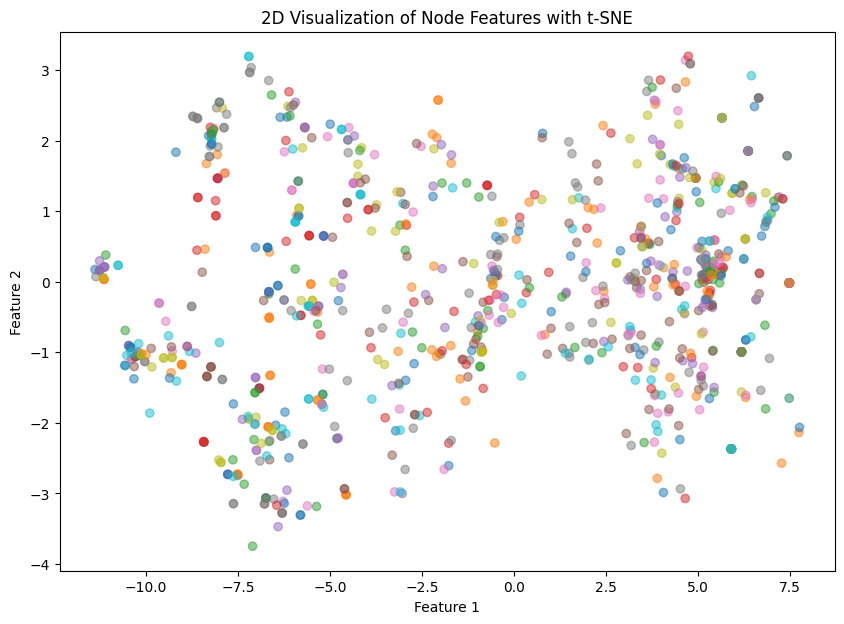

In [17]:
visualise(tsne_results, labels, '2D Visualization of Node Features with t-SNE')

# 9. Graph AE with skip & residual connections
3 GCNConv layers with skip connections.

## 

In [18]:
class ResidualVGAEEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualVGAEEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels)
        self.conv2_mu = GCNConv(2 * out_channels, out_channels)
        self.conv2_logstd = GCNConv(2 * out_channels, out_channels)
        self.shortcut = torch.nn.Linear(in_channels, out_channels)

    def forward(self, x, edge_index):
        identity = x
        x = F.relu(self.conv1(x, edge_index))
        mu = self.conv2_mu(x, edge_index)
        logstd = self.conv2_logstd(x, edge_index)

        if identity.size(-1) != mu.size(-1):
            identity = self.shortcut(identity)

        mu += identity
        logstd += identity

        return mu, logstd


data = main()
generate_train_test(data)
data = train_test_split_edges(data)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Parameters for visualization
out_channels = 2  # Set to 2 for 2D visualization
num_features = data.num_features
hidden_channels=16

model = VGAE(ResidualVGAEEncoder(num_features, out_channels)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training the GAE model to encode node features into 2D
for epoch in range(1, 201):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x.to(device), data.train_pos_edge_index.to(device))
    loss = model.recon_loss(z, data.train_pos_edge_index)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item()}')

# Encode and detach the features for visualization
encoded_features = model.encode(data.x.to(device), data.train_pos_edge_index.to(device)).detach().cpu().numpy()

# Visualization of the 2D encoded features
labels = data.y.cpu().numpy()



Data(x=[1000, 784], edge_index=[2, 4000], y=[1000], num_node_features=784, num_classes=10, num_features=784)
Number of node features: 784
Number of classes: 10
Number of features: 784


/home/asemerjak/.local/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


Epoch: 10, Loss: 3.1694278717041016
Epoch: 20, Loss: 1.2632560729980469
Epoch: 30, Loss: 1.4685825109481812
Epoch: 40, Loss: 1.233433723449707
Epoch: 50, Loss: 1.1795876026153564
Epoch: 60, Loss: 1.157193660736084
Epoch: 70, Loss: 1.1173205375671387
Epoch: 80, Loss: 1.1127322912216187
Epoch: 90, Loss: 1.1088398694992065
Epoch: 100, Loss: 1.1108006238937378
Epoch: 110, Loss: 1.0870726108551025
Epoch: 120, Loss: 1.0919444561004639
Epoch: 130, Loss: 1.1009085178375244
Epoch: 140, Loss: 1.083688497543335
Epoch: 150, Loss: 1.0804696083068848
Epoch: 160, Loss: 1.0873010158538818
Epoch: 170, Loss: 1.0912306308746338
Epoch: 180, Loss: 1.0697945356369019
Epoch: 190, Loss: 1.057685136795044
Epoch: 200, Loss: 1.0734460353851318


## 

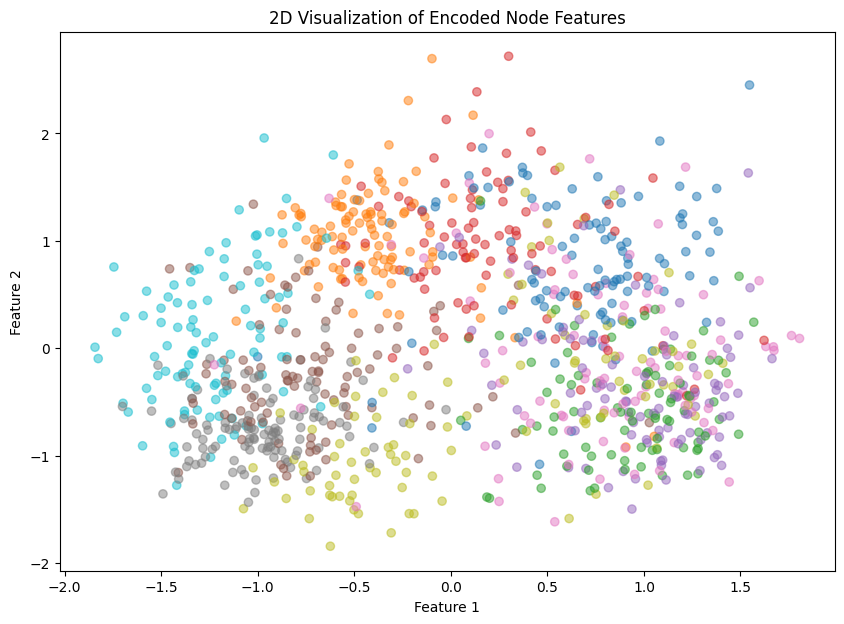

In [19]:
visualise(encoded_features, labels, '2D Visualization of Encoded Node Features')

# 10. Graph AE with residual connection
Three GCNConv layers with a residual connection.

## 

In [20]:
from torch_geometric.nn import GCNConv, GAE, VGAE, LayerNorm

class EnhancedVGAEEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(EnhancedVGAEEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels)
        self.ln1 = LayerNorm(2 * out_channels)
        self.skip_conv1 = GCNConv(in_channels, 2 * out_channels)
        self.conv2_mu = GCNConv(2 * out_channels, out_channels)
        self.conv2_logstd = GCNConv(2 * out_channels, out_channels)
        self.ln2_mu = LayerNorm(out_channels)
        self.ln2_logstd = LayerNorm(out_channels)

    def forward(self, x, edge_index):
        skip1 = F.relu(self.skip_conv1(x, edge_index))
        x = F.relu(self.conv1(x, edge_index))
        x = self.ln1(x + skip1)
        mu = self.conv2_mu(x, edge_index)
        logstd = self.conv2_logstd(x, edge_index)
        mu = self.ln2_mu(mu)
        logstd = self.ln2_logstd(logstd)
        return mu, logstd


data = main()
generate_train_test(data)
data = train_test_split_edges(data)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Parameters for visualization
out_channels = 2  # Set to 2 for 2D visualization
num_features = data.num_features
hidden_channels=16

model = VGAE(EnhancedVGAEEncoder(num_features, out_channels)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training the GAE model to encode node features into 2D
for epoch in range(1, 201):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x.to(device), data.train_pos_edge_index.to(device))
    loss = model.recon_loss(z, data.train_pos_edge_index)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item()}')

# Encode and detach the features for visualization
encoded_features = model.encode(data.x.to(device), data.train_pos_edge_index.to(device)).detach().cpu().numpy()

# Visualization of the 2D encoded features
labels = data.y.cpu().numpy()



Data(x=[1000, 784], edge_index=[2, 4000], y=[1000], num_node_features=784, num_classes=10, num_features=784)
Number of node features: 784
Number of classes: 10
Number of features: 784


/home/asemerjak/.local/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


Epoch: 10, Loss: 2.4803192615509033
Epoch: 20, Loss: 2.0407052040100098
Epoch: 30, Loss: 1.7506495714187622
Epoch: 40, Loss: 1.615046501159668
Epoch: 50, Loss: 1.564054012298584
Epoch: 60, Loss: 1.4582915306091309
Epoch: 70, Loss: 1.3602070808410645
Epoch: 80, Loss: 1.3235440254211426
Epoch: 90, Loss: 1.3310847282409668
Epoch: 100, Loss: 1.2627437114715576
Epoch: 110, Loss: 1.253067970275879
Epoch: 120, Loss: 1.2304518222808838
Epoch: 130, Loss: 1.239948034286499
Epoch: 140, Loss: 1.2025573253631592
Epoch: 150, Loss: 1.2191874980926514
Epoch: 160, Loss: 1.1784545183181763
Epoch: 170, Loss: 1.199495553970337
Epoch: 180, Loss: 1.143333911895752
Epoch: 190, Loss: 1.1493147611618042
Epoch: 200, Loss: 1.1467851400375366


## 

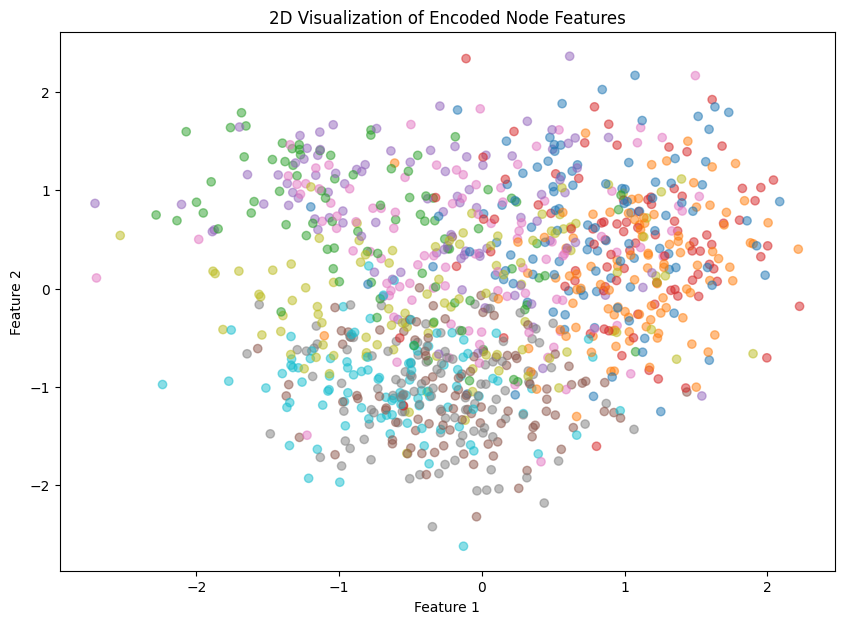

In [21]:
visualise(encoded_features, labels, '2D Visualization of Encoded Node Features')

# 11. Graph AE with attention & normalization
Two GATConv layers with layer normalization.

## 

In [22]:
from torch_geometric.nn import GATConv, LayerNorm

class ComplexVGAEEncoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(ComplexVGAEEncoder, self).__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=8, dropout=0.6)
        self.conv2 = GATConv(hidden_channels * 8, hidden_channels, heads=8, dropout=0.6)
        self.conv3_mu = GATConv(hidden_channels * 8, out_channels, heads=1, concat=False, dropout=0.6)
        self.conv3_logstd = GATConv(hidden_channels * 8, out_channels, heads=1, concat=False, dropout=0.6)
        self.shortcut = torch.nn.Linear(in_channels, out_channels)

    def forward(self, x, edge_index):
        identity = x
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.elu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.elu(self.conv2(x, edge_index))

        mu = self.conv3_mu(x, edge_index)
        logstd = self.conv3_logstd(x, edge_index)

        if identity.size(-1) != mu.size(-1):
            identity = self.shortcut(identity)

        mu += identity
        logstd += identity

        return mu, logstd


data = main()
generate_train_test(data)
data = train_test_split_edges(data)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Parameters for visualization
out_channels = 2  # Set to 2 for 2D visualization
num_features = data.num_features
hidden_channels=16

model = VGAE(ComplexVGAEEncoder(num_features, hidden_channels, out_channels)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training the GAE model to encode node features into 2D
for epoch in range(1, 201):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x.to(device), data.train_pos_edge_index.to(device))
    loss = model.recon_loss(z, data.train_pos_edge_index)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item()}')

# Encode and detach the features for visualization
encoded_features = model.encode(data.x.to(device), data.train_pos_edge_index.to(device)).detach().cpu().numpy()

labels = data.y.cpu().numpy()


Data(x=[1000, 784], edge_index=[2, 4000], y=[1000], num_node_features=784, num_classes=10, num_features=784)
Number of node features: 784
Number of classes: 10
Number of features: 784


/home/asemerjak/.local/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


Epoch: 10, Loss: 25.99003791809082
Epoch: 20, Loss: 27.225791931152344
Epoch: 30, Loss: 22.744735717773438
Epoch: 40, Loss: 22.093994140625
Epoch: 50, Loss: 24.441341400146484
Epoch: 60, Loss: 24.965656280517578
Epoch: 70, Loss: 26.334796905517578
Epoch: 80, Loss: 22.155670166015625
Epoch: 90, Loss: 26.05140495300293
Epoch: 100, Loss: 23.885177612304688
Epoch: 110, Loss: 25.690895080566406
Epoch: 120, Loss: 30.229873657226562
Epoch: 130, Loss: 27.721599578857422
Epoch: 140, Loss: 25.25214385986328
Epoch: 150, Loss: 23.695953369140625
Epoch: 160, Loss: 20.09990119934082
Epoch: 170, Loss: 19.57230567932129
Epoch: 180, Loss: 20.208066940307617
Epoch: 190, Loss: 17.304798126220703
Epoch: 200, Loss: 18.20119857788086


## 

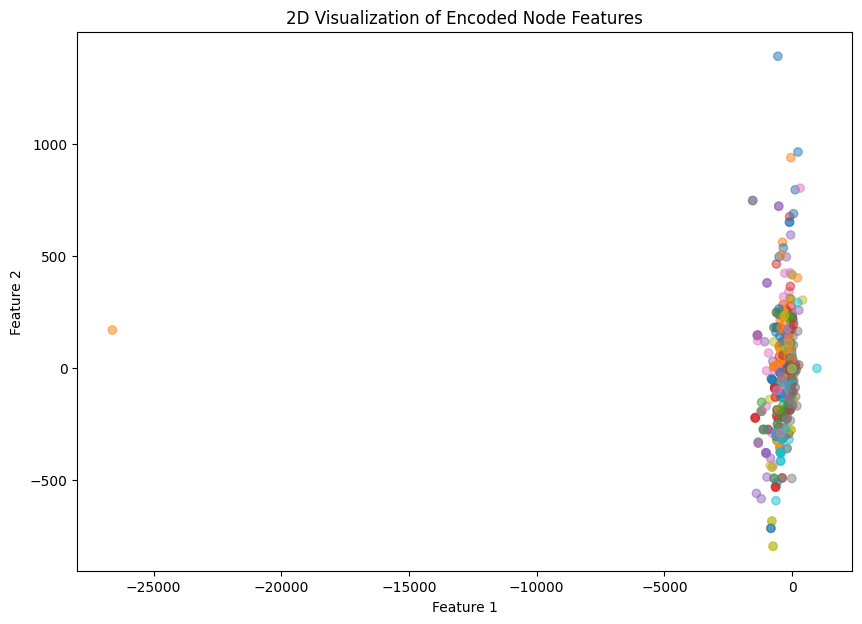

In [23]:
visualise(encoded_features, labels, '2D Visualization of Encoded Node Features')